In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np


In [3]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('Desktop/ML_Final_Project/CNN_train_dataframe.csv')
test_df = pd.read_csv('Desktop/ML_Final_Project/CNN_test_dataframe.csv')



In [5]:
# Assuming `df` is your training DataFrame and `test_df` is your testing DataFrame
X = df.drop('label', axis=1).values
y = df['label'].values
sc = StandardScaler()
X = sc.fit_transform(X)
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Determine the number of classes and input shape
num_classes = len(set(y_encoded))
input_shape = X.shape[1]


# Split data into training and testing sets for the training dataset
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train_tensor = torch.Tensor(X_train).unsqueeze(1).to(device)
y_train_tensor = torch.Tensor(y_train).long().to(device)
X_val_tensor = torch.Tensor(X_val).unsqueeze(1).to(device)
y_val_tensor = torch.Tensor(y_val).long().to(device)

# Create dataset and dataloader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:

import torch.nn.functional as F


class ResidualBlock(nn.Module):
    expansion = 1  # Set the expansion factor for the residual block

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.8):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout
        return out

class ResNetAudio(nn.Module):
    def __init__(self, block, num_classes, dropout_prob=0.3):
        super(ResNetAudio, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv1d(1, 64, kernel_size=7, stride=1, padding=3)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 32, 2, dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 64, 2, stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 128, 2, stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 256, 2, stride=2, dropout_prob=dropout_prob)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256 * block.expansion, num_classes)  # Adjusted input size for the fully connected layer
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.5):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(out_channels * block.expansion, out_channels, dropout_prob=dropout_prob))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)
        return x

In [7]:
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
# Assuming you have defined your train_loader, X_val_tensor, y_val_tensor, and other necessary variables

model = ResNetAudio(ResidualBlock, num_classes=num_classes).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=350, gamma=2)

num_epochs = 1500
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

    train_accuracy = correct_train_predictions / total_train_predictions * 100

    # Update the learning rate
    scheduler.step()

    # Validation accuracy
    if epoch % 100 == 0:
        model.eval()  # Set the model to evaluation mode
        correct_val_predictions = 0
        total_val_predictions = 0
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            _, predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (predicted == y_val_tensor).sum().item()
            total_val_predictions += y_val_tensor.size(0)

        test_accuracy = correct_val_predictions / total_val_predictions * 100
        model.train()  # Set the model back to training mode
        print(f"Epoch {epoch + 1}, Loss: {running_loss / total_train_predictions}, Train Accuracy: {train_accuracy}%, Val Accuracy: {test_accuracy}%")


Epoch 1, Loss: 0.057728610717603705, Train Accuracy: 27.222557557989134%, Val Accuracy: 31.0%
Epoch 101, Loss: 0.04400908506008081, Train Accuracy: 47.08976459429163%, Val Accuracy: 48.06896551724138%
Epoch 201, Loss: 0.034812432928949616, Train Accuracy: 58.08398723807882%, Val Accuracy: 61.0%
Epoch 301, Loss: 0.028206273775897562, Train Accuracy: 66.77589031646114%, Val Accuracy: 66.10344827586206%
Epoch 401, Loss: 0.02450253061562805, Train Accuracy: 71.6564628783306%, Val Accuracy: 68.10344827586206%
Epoch 501, Loss: 0.01997153745845154, Train Accuracy: 76.51978960075881%, Val Accuracy: 71.55172413793103%
Epoch 601, Loss: 0.017070630791270136, Train Accuracy: 79.81374493403467%, Val Accuracy: 72.20689655172414%
Epoch 701, Loss: 0.016170149141111652, Train Accuracy: 80.96921617659739%, Val Accuracy: 72.27586206896551%
Epoch 801, Loss: 0.015258218021786315, Train Accuracy: 82.19367077692506%, Val Accuracy: 72.9655172413793%
Epoch 901, Loss: 0.01343535009289421, Train Accuracy: 84.823

Classification Report:
               precision    recall  f1-score   support

    eighties       1.00      1.00      1.00         5
     fifties       0.78      0.71      0.75       205
    fourties       0.75      0.69      0.72       236
   seventies       0.82      0.75      0.78        36
     sixties       0.82      0.82      0.82        88
       teens       0.92      0.56      0.70       117
    thirties       0.71      0.74      0.72       389
    twenties       0.68      0.78      0.72       466

    accuracy                           0.73      1542
   macro avg       0.81      0.76      0.78      1542
weighted avg       0.74      0.73      0.73      1542

Confusion Matrix:
 [[  5   0   0   0   0   0   0   0]
 [  0 146   7   1   1   0  22  28]
 [  0   7 164   1   3   2  18  41]
 [  0   2   2  27   0   0   2   3]
 [  0   4   2   0  72   0   8   2]
 [  0   5   4   0   0  66  15  27]
 [  0   9  16   3   3   0 286  72]
 [  0  13  24   1   9   4  52 363]]


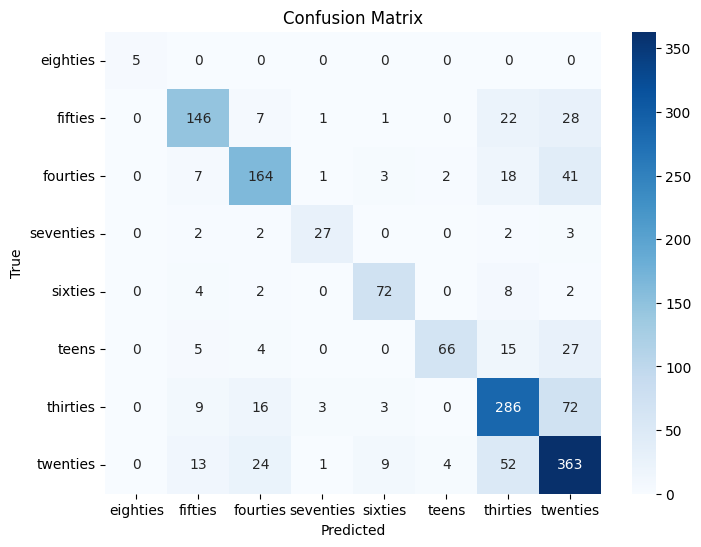

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have defined your model and label_encoder before this point

# Assuming 'test_df' is your test dataset

# Convert the test data to PyTorch tensors and move to GPU
X_test = test_df.drop('label', axis=1).values
X_test = sc.fit_transform(X_test)
y_test = test_df['label'].values
y_test_encoded = label_encoder.transform(y_test)

X_test_tensor = torch.Tensor(X_test).unsqueeze(1).to(device)
y_test_tensor = torch.Tensor(y_test_encoded).long().to(device)

# Evaluate the model on the test dataset
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    predicted = predicted.cpu().numpy()
    y_test_encoded = y_test_encoded.astype(int)

# Generate a classification report
report = classification_report(y_test_encoded, predicted, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, predicted)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
